In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tools # helper and plotting functions

import xdem
import pandas as pd
import numpy as np
from pyproj import Transformer
from pathlib import Path
import matplotlib.pyplot as plt

## Prerequisite

Install the NASA Ames Stereo Pipeline (ASP), for example with conda https://stereopipeline.readthedocs.io/en/latest/installation.html#conda-intro

### Coregistration tutorial

**Objective**  
Apply Iterative Closest Point (ICP) coregestration using ASP. This correction can be applied back to the camera positions, prior to a final bundle adjustment and dense cloud / DEM / ortho generation.

**This notebook demonstrates how to:**
- Introduce an artifical rotation to a [small mountainous region](https://maps.app.goo.gl/vSXHshtdiUqb5xj58) in the Casa Grande reference DEM. The region is chosen because it highlights offsets well. We assume this is the output from the first bundle adjustment and has a systematic offset.
- Correct the rotation error using the [ASP pc_align tool](https://stereopipeline.readthedocs.io/en/latest/tools/pc_align.html).
- Apply the transform back to the camera positions.

### Prepare reference DEM

In [3]:
reference_dem_path = '/Volumes/backup/data/history/data/casa_grande/aux_data/reference_dem_zoom.tif'
reference_dem_clip_path = './data/reference_dem_zoom_clip_aoi_10m.tif'

In [4]:
%%capture
!mkdir data
!gdalwarp -te 431000 3627000 436000 3634000 \
  -te_srs EPSG:26912 \
  -r cubic -tr 10 10 \
  -co TILED=YES -co COMPRESS=LZW -co BIGTIFF=IF_SAFER  \
  {reference_dem_path} {reference_dem_clip_path}

### Load reference DEM 

In [5]:
reference_dem = xdem.DEM(reference_dem_clip_path)

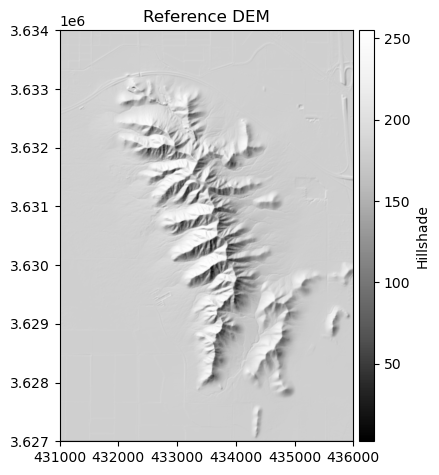

In [6]:
reference_dem_hillshade = reference_dem.hillshade()
reference_dem_hillshade.plot(cmap="Greys_r", cbar_title="Hillshade")
plt.title('Reference DEM');

### Create artificial ASP transform
These rotations and shifts are computed with respect to the earth center in EPSG:4978 (ECEF) 

In [7]:
transform_path = './data/transform.txt'

In [8]:
bounds = reference_dem.bounds

## Define rotation center
xc = (bounds.left + bounds.right) / 2 +1000 # shift rotation center 1km in x
yc = (bounds.bottom + bounds.top) / 2 +1000 # shift rotation center 1km in y
zc = np.nanmedian(reference_dem)

## Create rotation matrix
tools.write_asp_pivoted_rotation(transform_path, 
                                 (xc, yc, zc),
                                 rot_x_deg=0.1, 
                                 rot_y_deg=0.2, 
                                 rot_z_deg=0.0,
                                 crs_epsg=reference_dem.crs.to_epsg(),
                                );

In [9]:
! cat {transform_path}

0.99999390765779039 6.0923329304530558e-06 0.0034906460986589443 -11980.41396044055
0 0.99999847691328769 -0.0017453283658983088 5991.7751202053751
-0.0034906514152237321 0.0017453177327606357 0.99999238458035722 1802.1830437360331
0 0 0 1


### Apply artificial ICP transform

In [10]:
%%capture
!pc_align {Path(reference_dem_clip_path)} {Path(reference_dem_clip_path)} \
  --initial-transform {transform_path} \
  --num-iterations 0 \
  --max-displacement -1 \
  --save-transformed-source-points \
  -o data/run/run

In [11]:
%%capture
!point2dem data/run/run-trans_source.tif --tr 10 --t_srs EPSG:26912

In [12]:
dem = xdem.DEM('data/run/run-trans_source-DEM.tif')
dem = dem.reproject(reference_dem)

In [13]:
diff_before = dem - reference_dem

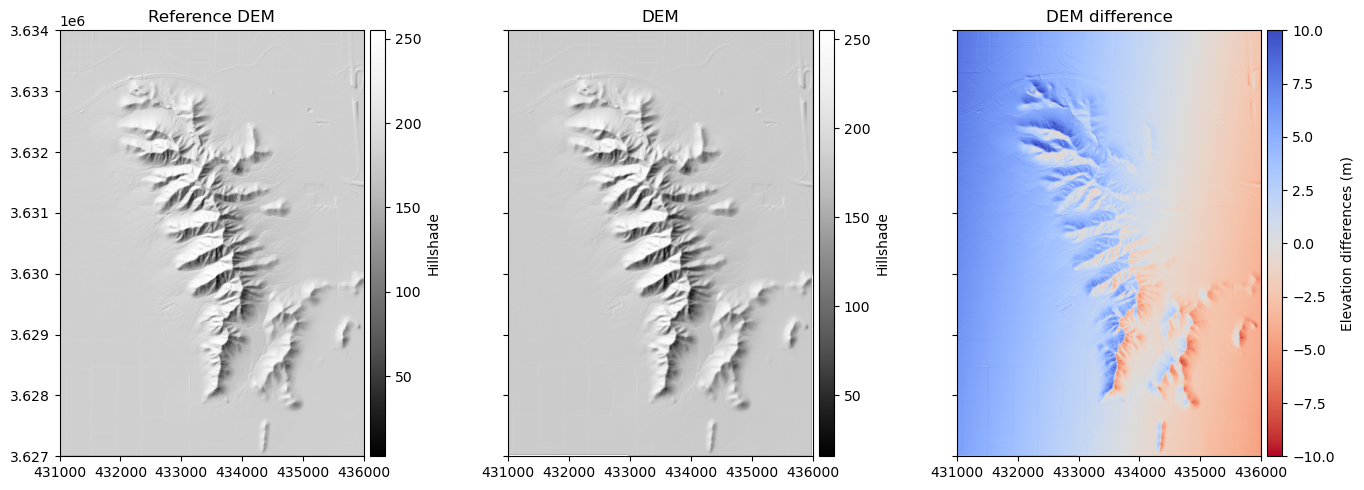

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(14,5))
reference_dem_hillshade.plot(ax=ax[0],cmap="Greys_r", cbar_title="Hillshade")
dem.hillshade().plot(ax=ax[1],cmap="Greys_r", cbar_title="Hillshade")
diff_before.plot(ax=ax[2],cmap="coolwarm_r", vmin=-10, vmax=10, cbar_title="Elevation differences (m)")

ax[0].set_title("Reference DEM")
ax[1].set_title("DEM")
ax[2].set_title("DEM difference")
ax[1].set_yticklabels([])
ax[2].set_yticklabels([])
plt.tight_layout()

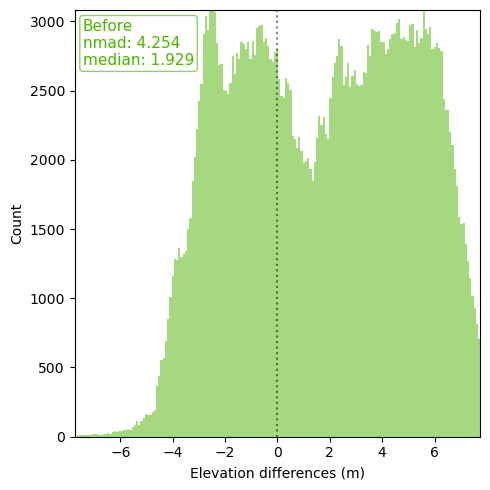

In [15]:
tools.plot_diff_histogram([diff_before.data],
                          ['Before'],
                          error_metrics = ['nmad', 'median']);

### Apply first ICP transform - point-to-plane

In [16]:
%%capture
!pc_align {Path(reference_dem_clip_path)} {Path('data/run/run-trans_source-DEM.tif')} \
  --max-displacement 2000 \
  --save-transformed-source-points \
  --outlier-ratio 0.75 \
  --alignment-method point-to-plane \
  -o run/run

In [17]:
%%capture
!point2dem run/run-trans_source.tif --tr 10 --t_srs EPSG:26912

In [18]:
icp_aligned_dem = xdem.DEM('run/run-trans_source-DEM.tif')
icp_aligned_dem = icp_aligned_dem.reproject(reference_dem)
diff_after = icp_aligned_dem - reference_dem

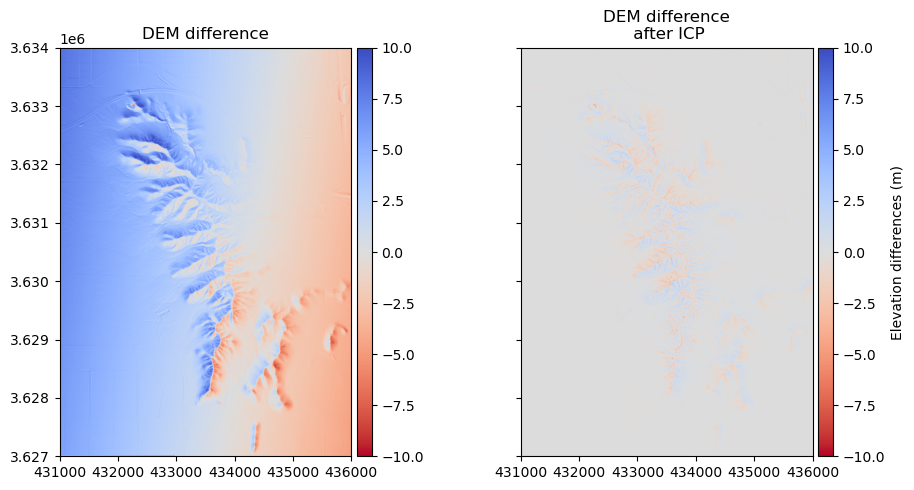

In [19]:
dh_vmax = 10
fig, ax = plt.subplots(1, 2, figsize=(10,5))
diff_before.plot(cmap="coolwarm_r", vmin=-dh_vmax, vmax=dh_vmax, ax=ax[0])
diff_after.plot(cmap="coolwarm_r", vmin=-dh_vmax, vmax=dh_vmax, ax=ax[1], cbar_title="Elevation differences (m)")
ax[0].set_title("DEM difference")
ax[1].set_title("DEM difference\n after ICP")
ax[1].set_yticklabels([])
plt.tight_layout()

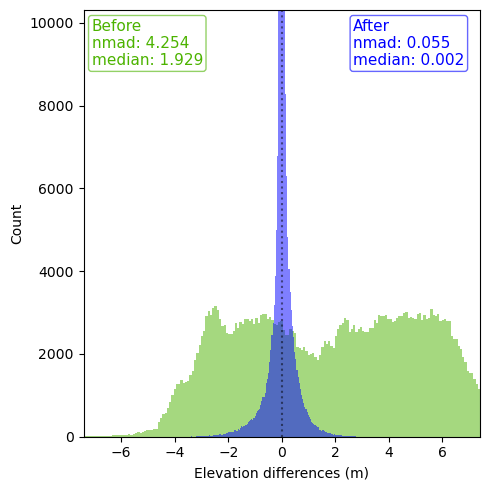

In [20]:
tools.plot_diff_histogram([diff_before.data, diff_after.data],
                          ['Before', 'After'],
                          error_metrics = ['nmad', 'median']);

### Load camera extrinsics before and after bundle adjustment

In [21]:
initial_extrinsics_path = '/Volumes/backup/data/history/data/casa_grande/aerial_images/1978_09_06/camera_model_extrinsics.csv'
bundle_adjusted_extrinsics_path = '/Volumes/backup/data/history/tutorial_data/bundle_adjusted_camera_model_extrinsics.csv'

In [22]:
initial_extrinsics_df = pd.read_csv(initial_extrinsics_path)
bundle_adjusted_extrinsics_df = pd.read_csv(bundle_adjusted_extrinsics_path)[initial_extrinsics_df.keys()]

In [23]:
initial_extrinsics_df.head()

,image_file_name,lon,lat,alt
0,ARBCSRD00010006.tif,-111.716543,32.915160,3810
1,ARBCSRD00010007.tif,-111.716891,32.894945,3810
2,ARBCSRD00010008.tif,-111.716569,32.872712,3810
3,ARBCSRD00010009.tif,-111.716386,32.852701,3810
4,ARBCSRD00010015.tif,-111.757795,32.917873,3810


In [24]:
bundle_adjusted_extrinsics_df.head()

,image_file_name,lon,lat,alt
0,ARBCSRD00010006.tif,-111.716176,32.916803,4360.998948
1,ARBCSRD00010007.tif,-111.716309,32.895240,4357.913488
2,ARBCSRD00010008.tif,-111.716802,32.873668,4355.761675
3,ARBCSRD00010009.tif,-111.717433,32.852088,4361.177138
4,ARBCSRD00010015.tif,-111.758647,32.920173,4359.234493


  X (longitude) shift: mean=-0.002378°, std=0.002229°
  Y (latitude) shift: mean=-0.000154°, std=0.002055°
  Z (altitude) shift: mean=553.705m, std=4.870m
Auto-calculated oval scale factor: 1.81 m/m


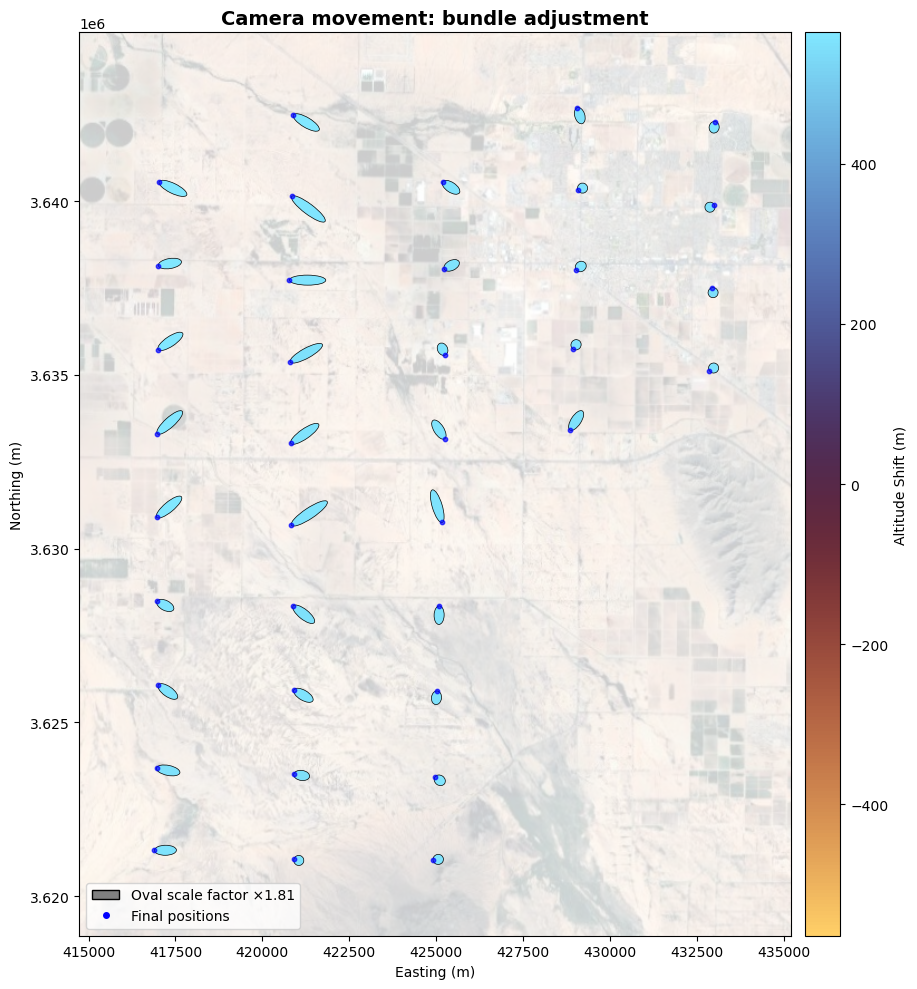


Dataset statistics:
  Initial positions: 37 points
  Final positions: 37 points
  Matched positions: 37 points

Position shift statistics (projected coordinates):
  X shift: mean=-222.69m, std=205.76m
  Y shift: mean=-15.31m, std=224.77m
  Altitude shift: mean=553.70m, std=4.87m
  Oval scale factor used: 1.81


In [25]:
tools.plot_extrinsics_comparison(initial_extrinsics_df, 
                                 bundle_adjusted_extrinsics_df,
                                 plot_ovals = True,
                                 oval_scale_factor = None,
                                 oval_alpha = 1,
                                 basemap_alpha = 0.2,
                                 basemap_xyz = "https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
                                 colormap = "managua",
                                 cbar_title = "Altitude Shift (m)",
                                 verbose = True,
                                 show_ticks = True,
                                 plot_title = "Camera movement: bundle adjustment",
                                )

### Apply transform back to camera positions

#### Bundle adjusted camera positions

In [26]:
bundle_adjusted_extrinsics_df.head()

,image_file_name,lon,lat,alt
0,ARBCSRD00010006.tif,-111.716176,32.916803,4360.998948
1,ARBCSRD00010007.tif,-111.716309,32.895240,4357.913488
2,ARBCSRD00010008.tif,-111.716802,32.873668,4355.761675
3,ARBCSRD00010009.tif,-111.717433,32.852088,4361.177138
4,ARBCSRD00010015.tif,-111.758647,32.920173,4359.234493


#### Convert camera positions to ECEF

In [27]:
to_ecef = Transformer.from_crs("EPSG:4326", "EPSG:4978", always_xy=True)

df = bundle_adjusted_extrinsics_df.copy()

lon = df['lon'].to_numpy()
lat = df['lat'].to_numpy()
alt = df['alt'].to_numpy()

X, Y, Z = to_ecef.transform(lon, lat, alt)
XYZ = np.column_stack([X, Y, Z]) 

#### Exctract ICP transform

In [28]:
# ! cat {transform_path}

In [29]:
M = np.loadtxt(transform_path) # 4x4 matrix
R = M[:3, :3]                  # rotation
t = M[:3, 3]                   # translation
# print(R)
# print(T)

In [30]:
tools.analyze_transform(R);

=== Transform analysis ===
Scale: sx=1.000000, sy=1.000000, sz=1.000000
Shear (dot products): xy=0.000000e+00, xz=4.336809e-19, yz=0.000000e+00
Rotation (deg): rx=0.100000, ry=0.200000, rz=0.000000


#### Apply transform to camera positions

In [31]:
XYZ_t = (XYZ @ R.T) + t

In [32]:
to_geo  = Transformer.from_crs("EPSG:4978", "EPSG:4326", always_xy=True)

lon_t, lat_t, h_t = to_geo.transform(XYZ_t[:,0], XYZ_t[:,1], XYZ_t[:,2])

transformed_extrinsics_df = bundle_adjusted_extrinsics_df.copy()
transformed_extrinsics_df["lon"] = lon_t
transformed_extrinsics_df["lat"] = lat_t
transformed_extrinsics_df["alt"] = h_t

#### Final updated positions

In [33]:
transformed_extrinsics_df.head()

,image_file_name,lon,lat,alt
0,ARBCSRD00010006.tif,-111.715711,32.916836,4367.760888
1,ARBCSRD00010007.tif,-111.715927,32.895274,4363.918894
2,ARBCSRD00010008.tif,-111.716504,32.873702,4361.081357
3,ARBCSRD00010009.tif,-111.717219,32.852125,4365.838138
4,ARBCSRD00010015.tif,-111.758168,32.920323,4374.484471


### Examine shifts

  X (longitude) shift: mean=0.000137°, std=0.000234°
  Y (latitude) shift: mean=0.000317°, std=0.000154°
  Z (altitude) shift: mean=23.919m, std=10.347m
Auto-calculated oval scale factor: 17.46 m/m


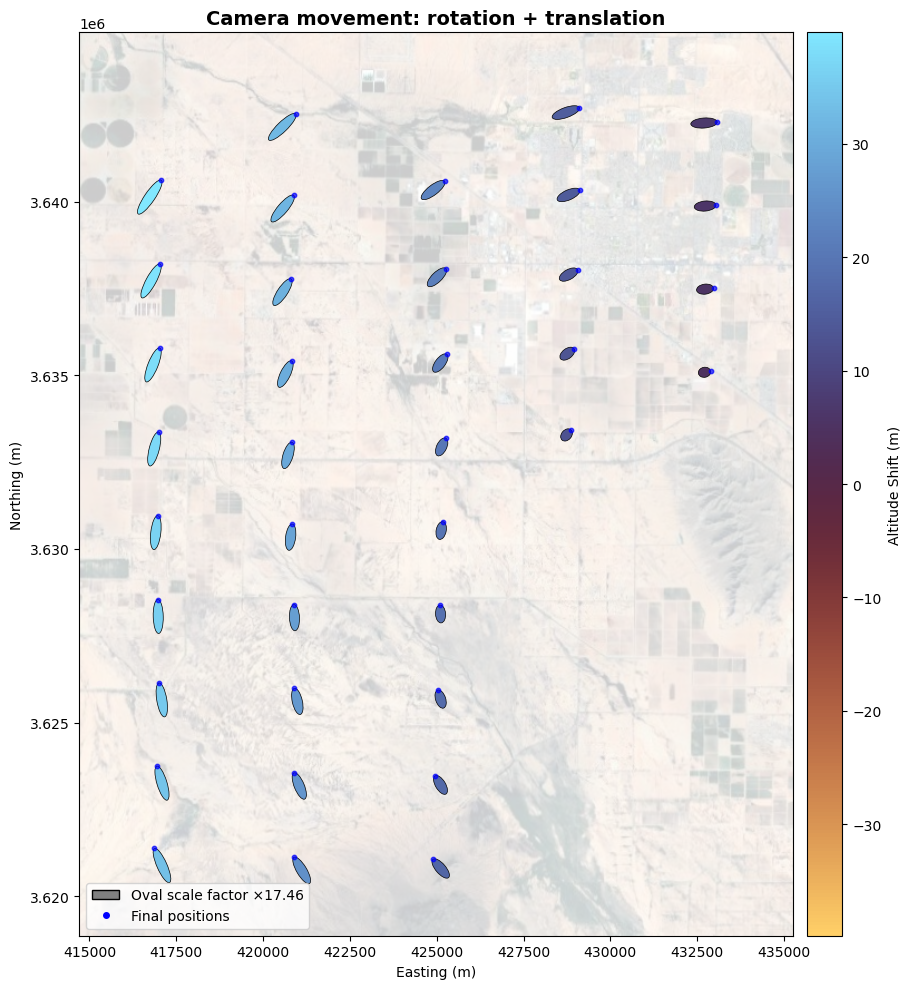


Dataset statistics:
  Initial positions: 37 points
  Final positions: 37 points
  Matched positions: 37 points

Position shift statistics (projected coordinates):
  X shift: mean=13.05m, std=21.52m
  Y shift: mean=35.04m, std=16.89m
  Altitude shift: mean=23.92m, std=10.35m
  Oval scale factor used: 17.46


In [34]:
tools.plot_extrinsics_comparison(bundle_adjusted_extrinsics_df,
                                 transformed_extrinsics_df, 
                                 plot_ovals = True,
                                 oval_scale_factor = None,
                                 oval_alpha = 1,
                                 basemap_alpha = 0.2,
                                 basemap_xyz = "https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
                                 colormap = "managua",
                                 cbar_title = "Altitude Shift (m)",
                                 verbose = True,
                                 show_ticks = True,
                                 plot_title = "Camera movement: rotation + translation",
                                )

### Finally, re-run bundle adjustment with updated camera positions...